In [56]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack, csr_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:

path = "/content/drive/My Drive/capFantasticFour/"

In [4]:
d = pd.read_csv(path + "Datasets/balanced_data.csv")



In [5]:
d.head()

,Label,Preprocessed_Content,sentiment,hate_speech_count,pos_tags,word2vec,sbert_embedding,lexical_diversity,sentence_complexity
0,0,politic power g g lot power accord constitutio...,-0.053125,1,"['ADJ', 'NOUN', 'NOUN', 'PROPN', 'NOUN', 'NOUN...",[-0.03289668 0.02179972 0.03996785 0.122357...,[-5.88354059e-02 1.34056015e-02 2.37510502e-...,0.791667,0
1,1,differentiate white man white car,0.000000,0,"['ADJ', 'ADJ', 'NOUN', 'ADJ', 'NOUN']",[ 7.32910186e-02 8.39111358e-02 -3.10058594e-...,[ 9.96661186e-03 1.11034006e-01 2.08890960e-...,0.800000,0
2,1,requirement job president male stillwater hill...,0.000000,0,"['NOUN', 'NOUN', 'NOUN', 'PROPN', 'PROPN', 'PR...",[-6.61621094e-02 3.15115787e-02 2.76576448e-...,[-5.81887439e-02 1.36256441e-02 1.53751895e-...,1.000000,0
3,0,mmm yes slut lazy henceforth use undo thank br...,-0.066667,1,"['INTJ', 'INTJ', 'PROPN', 'PROPN', 'ADV', 'VER...",[-0.04728917 0.02167184 -0.00804901 0.138368...,[-8.70714635e-02 6.90844133e-02 5.56385703e-...,0.821429,0
4,0,easy dennis brown hack wikipedia account write...,0.433333,0,"['PROPN', 'PROPN', 'PROPN', 'PROPN', 'PROPN', ...",[ 4.82566133e-02 3.74228731e-02 -5.38690723e-...,[-5.78395948e-02 1.60150453e-02 -5.26245423e-...,1.000000,0


In [6]:
d['sbert_embedding'].shape

(60000,)

In [8]:
def convert_embedding(embedding):
    if isinstance(embedding, np.ndarray):
        return embedding
    elif isinstance(embedding, list):
        return np.array(embedding, dtype=np.float32)
    elif isinstance(embedding, str):
        embedding = embedding.strip("[]")
        embedding = np.array([float(x) for x in embedding.split()], dtype=np.float32)
        return embedding
    else:
        return np.zeros(768, dtype=np.float32)

d['sbert_embedding'] = d['sbert_embedding'].apply(convert_embedding)

embeddings = np.stack(d['sbert_embedding'].values)


print("Embeddings Shape:", embeddings.shape)

Embeddings Shape: (60000, 384)


In [ ]:
#faiss_index = faiss.IndexFlatL2(embeddings.shape[1])
#faiss_index.add(embeddings)

In [ ]:
tfidf = TfidfVectorizer(ngram_range=(2, 3), stop_words='english')
X_tfidf = tfidf.fit_transform(d['Preprocessed_Content'])

In [ ]:
vectorizer = CountVectorizer(ngram_range=(2, 3), stop_words='english')
X_bow = vectorizer.fit_transform(d['Preprocessed_Content'])

In [ ]:
scaler = StandardScaler()
scaled_numerical_features = scaler.fit_transform(d[['sentiment', 'hate_speech_count', 'lexical_diversity', 'sentence_complexity']])
dense_features = csr_matrix(scaled_numerical_features)

In [ ]:
X_tfidf

In [ ]:
X_bow

In [36]:
X = hstack([
    X_tfidf,
    #X_bow,
    embeddings,
    #dense_features
])




In [9]:
Y = d['Label']

In [37]:
X.shape
#type(X)

(60000, 2335462)

**Will use only bert embeddings here as it will crash**

In [47]:
X_train, X_test, Y_train, Y_test = train_test_split(embeddings, Y, test_size=0.4, random_state=42, stratify=Y)

In [48]:
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)


X_train shape: (36000, 384)
Y_train shape: (36000,)
X_test shape: (24000, 384)
Y_test shape: (24000,)


In [49]:
# Reshape embeddings for LSTM (sequence length = 1)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [50]:
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)


X_train shape: (36000, 1, 384)
Y_train shape: (36000,)
X_test shape: (24000, 1, 384)
Y_test shape: (24000,)


In [53]:
lstm_model = Sequential()

#lstm_model.add(LSTM(128, return_sequences=False, input_shape=(1, X_train.shape[1])))
lstm_model.add(LSTM(128, return_sequences=False, input_shape=(1, 384)))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(1, activation = 'sigmoid'))
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(lstm_model.summary())

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 128)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 262,785 (1.00 MB)

 Trainable params: 262,785 (1.00 MB)

 Non-trainable params: 0 (0.00 B)

None


In [66]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [67]:
batch_size = 256
epochs  = 200

history = lstm_model.fit(X_train, np.asarray(Y_train), validation_data=(X_test, np.asarray(Y_test)), batch_size = batch_size, epochs = epochs, callbacks=[early_stopping])


Epoch 1/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8545 - loss: 0.3342 - val_accuracy: 0.8206 - val_loss: 0.4030
Epoch 2/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8594 - loss: 0.3281 - val_accuracy: 0.8204 - val_loss: 0.4035
Epoch 3/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.8590 - loss: 0.3276 - val_accuracy: 0.8202 - val_loss: 0.4029
Epoch 4/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.8601 - loss: 0.3220 - val_accuracy: 0.8210 - val_loss: 0.4036
Epoch 5/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8626 - loss: 0.3216 - val_accuracy: 0.8214 - val_loss: 0.4036
Epoch 6/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8645 - loss: 0.3147 - val_accuracy: 0.8197 - val_loss: 0.4054
Epoch 7/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8643 - loss: 0.3147 - val_accuracy: 0.8215 - val_loss: 0.4038
Epoch 8/200
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.8651 - loss: 0.3130 - 

In [ ]:
lstm_model.save('lstm_hs.h5')


In [ ]:
#from tensorflow.keras.models import load_model
#loaded_model = load_model('lstm_hs.h5')

In [71]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score


# Predictions (threshold of 0.5 for binary classification)
y_pred = (lstm_model.predict(X_test) > 0.5).astype(int)

# Calculate Precision, Recall, F1 Score, and Accuracy (Bias)
precision = precision_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred)
accuracy = accuracy_score(Y_test, y_pred)

# Bias (Accuracy) is just accuracy, but printed explicitly
bias = accuracy

# Print metrics
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))
print("Accuracy (Bias): {:.4f}".format(bias))

# Display classification report (includes precision, recall, f1 score)
print("\nClassification Report:\n")
print(classification_report(Y_test, y_pred, target_names=['Non-Hate', 'Hate']))

750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
Precision: 0.8033
Recall: 0.8482
F1 Score: 0.8251
Accuracy (Bias): 0.8202

Classification Report:

              precision    recall  f1-score   support

    Non-Hate       0.84      0.79      0.82     12000
        Hate       0.80      0.85      0.83     12000

    accuracy                           0.82     24000
   macro avg       0.82      0.82      0.82     24000
weighted avg       0.82      0.82      0.82     24000



              precision    recall  f1-score   support

    Non-Hate       0.84      0.79      0.82     12000
        Hate       0.80      0.85      0.83     12000

    accuracy                           0.82     24000
   macro avg       0.82      0.82      0.82     24000
weighted avg       0.82      0.82      0.82     24000



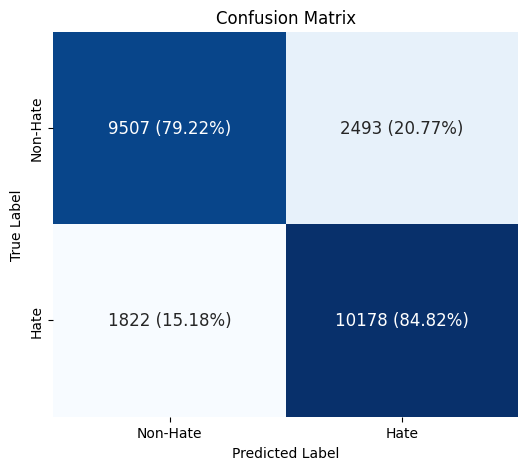

In [72]:
# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    # Create a combined matrix for annotations
    combined_matrix = np.array([["{} ({:.2f}%)".format(cm[i, j], cm_percent[i, j])
                                for j in range(cm.shape[1])]
                               for i in range(cm.shape[0])])

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=combined_matrix, fmt='', cmap='Blues', cbar=False,
                xticklabels=['Non-Hate', 'Hate'],
                yticklabels=['Non-Hate', 'Hate'],
                annot_kws={"size": 12})

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Display Metrics
print(classification_report(Y_test, y_pred, target_names=['Non-Hate', 'Hate']))

# Plot the confusion matrix
plot_confusion_matrix(Y_test, y_pred)